In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# 6.2 Data preparation

#### [Data Source](https://github.com/gastonstat/CreditScoring)

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.head(3)

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985


In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_');

- levels(Status) = c("good", "bad")                                   
- levels(Home) = c("rent", "owner", "priv", "ignore", "parents", "other")
- levels(Marital) = c("single", "married", "widow", "separated", "divorced") 
- levels(Records) = c("no_rec", "yes_rec")                            
- levels(Job) = c("fixed", "partime", "freelance", "others")          

In [4]:
df['status'].value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [5]:
status_values = {
    1: 'ok', 
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df['home'].value_counts()

home
2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: count, dtype: int64

In [7]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

In [8]:
df['marital'].value_counts()

marital
2    3241
1     978
4     130
3      67
5      38
0       1
Name: count, dtype: int64

In [9]:
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

In [10]:
df.records.value_counts()

records
1    3682
2     773
Name: count, dtype: int64

In [11]:
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

In [12]:
df.job.value_counts()

job
1    2806
3    1024
2     452
4     171
0       2
Name: count, dtype: int64

In [13]:
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [14]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


### Missing values

#### Missing values are coded as 99999999

In [15]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [16]:
for col in ['income', 'assets', 'debt']:
    df[col] = df[col].replace(to_replace = 99999999, value = np.nan)


In [17]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [18]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [19]:
df = df[df.status != 'unk'].reset_index(drop = True)

In [20]:
df_full_train, df_test = train_test_split(df, test_size = 0.2,
                                          random_state = 11)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25,
                                    random_state = 11)

df_full_train = df_full_train.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_full_train = (df_full_train.status == 'default').astype('int').values
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

del df_full_train['status']
del df_train['status']
del df_val['status']
del df_test['status']

# 6.3 Decision Tree
- How a decision tree looks like
- Training a decision tree
- Overfitting
- Controlling the size of the tree

In [21]:
df.head(n = 20)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
5,ok,1,owner,60,36,married,no,fixed,75,214.0,3500.0,0.0,650,1645
6,ok,29,owner,60,44,married,no,fixed,75,125.0,10000.0,0.0,1600,1800
7,ok,9,parents,12,27,single,no,fixed,35,80.0,0.0,0.0,200,1093
8,ok,0,owner,60,32,married,no,freelance,90,107.0,15000.0,0.0,1200,1957
9,default,0,parents,48,41,married,no,partime,90,80.0,0.0,0.0,1200,1468


In [22]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else: return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else: return 'default'

In [23]:
client = df_train.iloc[0].to_dict()
client

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [24]:
assess_risk(client)

'ok'

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [26]:
dv = DictVectorizer(sparse = False)

In [261]:
train_dicts = df_train.fillna(0).to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [262]:
val_dicts = df_val.fillna(0).to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [30]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred) # auc score on validation dataset

0.6517037611101693

In [31]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred) # auc score on training dataset dataset

1.0

That's a case of overfitting - our model on the training data performs perfectly, but fails on validation

Let's change the depth parameter: restring the size of the tree to 2 levels:

In [32]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc: %.3f' % auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val auc: %.3f' % auc)

train auc: 0.776
val auc: 0.739


#### It's even better than the previous tree!

In [33]:
from sklearn.tree import export_text

In [34]:
print(export_text(dt, feature_names = dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



#  6.4 Decision Tree Learning Algorithm

In [35]:
# With one feature
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]
df_example = pd.DataFrame(data, columns = ['assets', 'status'])

In [36]:
df_example = df_example.sort_values('assets')
df_example = df_example.reset_index(drop = True)
df_example

,assets,status
0,0,default
1,2000,default
2,3000,default
3,4000,ok
4,5000,ok
5,5000,ok
6,8000,default
7,9000,ok


In [37]:
from IPython.display import display

In [38]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]
for T in Ts:
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    print(f'Threshold = {T}')
    
    display(df_left)
    display(df_left.status.value_counts(normalize = True))
    display(df_right)
    display(df_right.status.value_counts(normalize = True))
    
    print("-----------------------------------")

Threshold = 0


,assets,status
0,0,default


status
default    1.0
Name: proportion, dtype: float64

,assets,status
1,2000,default
2,3000,default
3,4000,ok
4,5000,ok
5,5000,ok
6,8000,default
7,9000,ok


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

-----------------------------------
Threshold = 2000


,assets,status
0,0,default
1,2000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,status
2,3000,default
3,4000,ok
4,5000,ok
5,5000,ok
6,8000,default
7,9000,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

-----------------------------------
Threshold = 3000


,assets,status
0,0,default
1,2000,default
2,3000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,status
3,4000,ok
4,5000,ok
5,5000,ok
6,8000,default
7,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

-----------------------------------
Threshold = 4000


,assets,status
0,0,default
1,2000,default
2,3000,default
3,4000,ok


status
default    0.75
ok         0.25
Name: proportion, dtype: float64

,assets,status
4,5000,ok
5,5000,ok
6,8000,default
7,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

-----------------------------------
Threshold = 5000


,assets,status
0,0,default
1,2000,default
2,3000,default
3,4000,ok
4,5000,ok
5,5000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

,assets,status
6,8000,default
7,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

-----------------------------------
Threshold = 8000


,assets,status
0,0,default
1,2000,default
2,3000,default
3,4000,ok
4,5000,ok
5,5000,ok
6,8000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

,assets,status
7,9000,ok


status
ok    1.0
Name: proportion, dtype: float64

-----------------------------------


In [39]:
# with two feature
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]
df_example = pd.DataFrame(data, columns = ['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [40]:
df_example = df_example.sort_values('debt')
df_example = df_example.reset_index(drop = True)
df_example

,assets,debt,status
0,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,3000,2000,default
7,8000,3000,default


In [41]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
      'debt': [500, 1000, 2000]
}

In [42]:
for feature, Ts in thresholds.items():
    print(feature)
    for T in Ts:
        print(f'Threshold = {T}')
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        

        display(df_left)
        display(df_left.status.value_counts(normalize = True))
        display(df_right)
        display(df_right.status.value_counts(normalize = True))

        print("----------------------------")
    print("##################################")

assets
Threshold = 0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,debt,status
0,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,3000,2000,default
7,8000,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

----------------------------
Threshold = 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,debt,status
0,9000,500,ok
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,3000,2000,default
7,8000,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

----------------------------
Threshold = 3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
6,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

,assets,debt,status
0,9000,500,ok
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,8000,3000,default


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

----------------------------
Threshold = 4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
6,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64

,assets,debt,status
0,9000,500,ok
3,5000,1000,ok
4,5000,1000,ok
7,8000,3000,default


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

----------------------------
Threshold = 5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

,assets,debt,status
0,9000,500,ok
7,8000,3000,default


status
ok         0.5
default    0.5
Name: proportion, dtype: float64

----------------------------
Threshold = 8000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,3000,2000,default
7,8000,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

,assets,debt,status
0,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

----------------------------
##################################
debt
Threshold = 500


,assets,debt,status
0,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,3000,2000,default
7,8000,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

----------------------------
Threshold = 1000


,assets,debt,status
0,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

,assets,debt,status
6,3000,2000,default
7,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

----------------------------
Threshold = 2000


,assets,debt,status
0,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

,assets,debt,status
7,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

----------------------------
##################################


# 6.5 Decision Tree Parameter Tuning
- selecting max_depth: The maximum depth of the tree
- selecting min_samples_leaf: The minimum number of samples required to be in a leaf node

In [43]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth = depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.754
  10 -> 0.700
  15 -> 0.683
  20 -> 0.662
None -> 0.654


| depth | auc |
|----------|----------|
| 4        | 0.761    |
| 5        | 0.766    |
| 6        | 0.759    |

For the following depth, auc score is almost the same. We will take depth 4.
Comparing depth 5 and 6, the tree with depth 4 is more simple and easy to understand.

In [44]:
scores = []
for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 50, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [45]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores.sort_values(by = 'auc', ascending = False)

,max_depth,min_samples_leaf,auc
21,6,15,0.785250
20,6,10,0.778299
24,6,100,0.776434
13,5,20,0.774028
22,6,20,0.773634
12,5,15,0.772723
23,6,50,0.770289
25,6,200,0.768267
10,5,5,0.767755
9,5,1,0.766938


In [46]:
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns=['max_depth'],
                values=['auc'])
df_scores_pivot

auc                    
max_depth                4         5         6
min_samples_leaf                              
1                 0.761283  0.766938  0.749564
5                 0.761283  0.767755  0.762212
10                0.761283  0.762276  0.778299
15                0.763726  0.772723  0.785250
20                0.760910  0.774028  0.773634
50                0.753457  0.766753  0.770289
100               0.755937  0.763384  0.776434
200               0.747260  0.759073  0.768267
500               0.679842  0.679842  0.679842

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

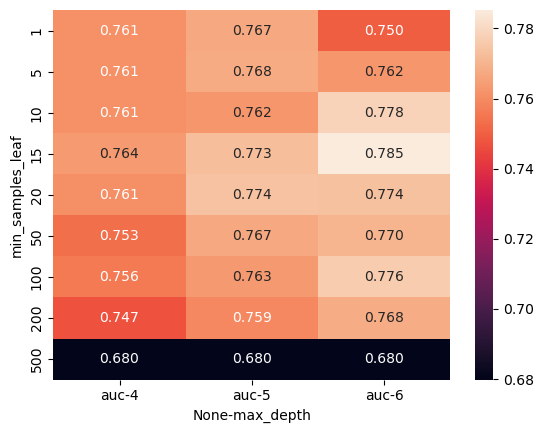

In [47]:
sns.heatmap(df_scores_pivot, annot = True, fmt = '.3f')

> From the heatmap, for `min_samples_leaf = 15` and `max_depth = 6`, we get the maximum AUC. First, we have selected the best depth `(4, 5, or 6)` for which AUC is maximized. Then for these selected depths, we iterate different `min_samples_leaf` and select the best one.

> This way of electing the parameters may be suboptimal. Because we don't iterate over all the depth in the first phase. There may be another depth for which the AUC score is even better. But if the dataset is big, we can not try every possible combination to select the best parameters set. In this case, the process we followed can be efficient.


In [48]:
# Iterate over more max_depth
scores = []
for depth in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 5, 10, 15, 20, 50, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores.sort_values(by = 'auc', ascending = False).head()

,max_depth,min_samples_leaf,auc
39,10.0,15,0.789216
57,20.0,15,0.788671
48,15.0,15,0.787112
66,NaN,15,0.786346
21,6.0,15,0.785080


This time `min_samples_leaf = 15` and `max_depth = 10`, we get the maximum AUC.

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

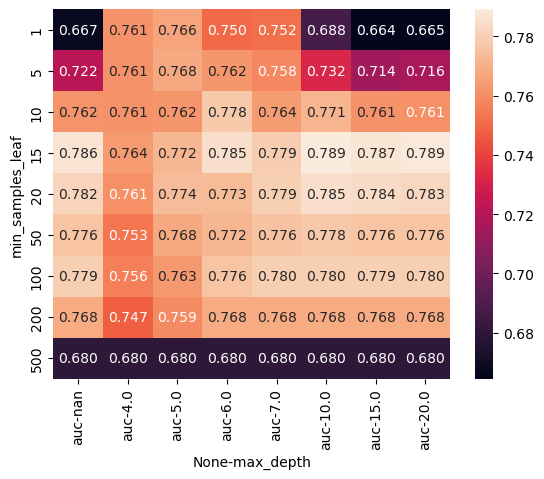

In [49]:
df_scores_pivot = df_scores.pivot(index = 'min_samples_leaf', columns=['max_depth'],
                values=['auc'])
sns.heatmap(df_scores_pivot, annot = True, fmt = '.3f')

We still select the Decision Tree with `min_samples_leaf = 15` and `max_depth = 6`. Because it is small tree and performace is also good.

In [50]:
# Final Training
dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val auc: %.3f' % auc)

val auc: 0.785


These parameters are commonly used for controlling the complexity of decision trees and preventing overfitting. By specifying a maximum depth and a minimum number of samples per leaf, you strike a balance between capturing patterns in the data and preventing the model from fitting the noise in the data too closely. These hyperparameters are often tuned to find the best trade-off between model performance and complexity for a specific dataset.

# 6.6 Ensembles Learning and Random Forrest
- Board of experts
- Ensembling models
- Random Forrest - ensembling decision trees
- Tuning random forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7847896636070815

Every tree of the Random Forrest gets a random subset of parameters. So if we run the code multiple times, every time the AUC will be different.

To understand how much it changes, we can repeat it 100 times and look at the mean and the standard deviation

In [53]:
aucs = []

for i in range(100):
    rf = RandomForestClassifier(n_estimators = 10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    aucs.append(auc)


auc_mean = np.mean(aucs)
auc_std = np.std(aucs)

print('%.3f +- %.3f' % (auc_mean, auc_std))
print('%.3f -- %.3f' % (auc_mean -  auc_std, auc_mean + auc_std))

0.785 +- 0.000
0.785 -- 0.785


To fix this issue, let's set the seed

In [54]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

#### Now, we will check how AUC depends on the number of trees.

In [55]:
aucs = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators = n, random_state = 3)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    
    print('%3s -> %.3f' % (n, auc))
    aucs.append((n, auc))

 10 -> 0.781
 20 -> 0.801
 30 -> 0.813
 40 -> 0.815
 50 -> 0.816
 60 -> 0.817
 70 -> 0.818
 80 -> 0.818
 90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


In [56]:
columns = ['n_estimators', 'auc']
df_scores = pd.DataFrame(aucs, columns=columns)
df_scores

,n_estimators,auc
0,10,0.781115
1,20,0.800737
2,30,0.813434
3,40,0.815420
4,50,0.815962
5,60,0.816843
6,70,0.818490
7,80,0.817863
8,90,0.819828
9,100,0.819043


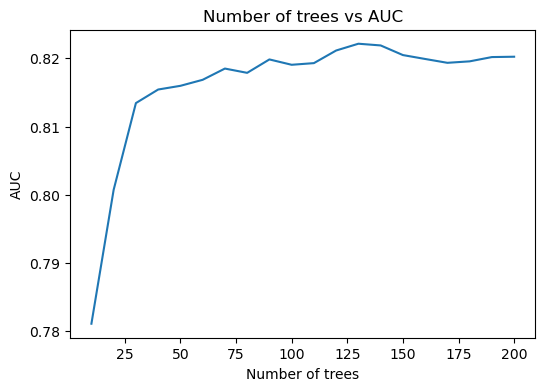

In [57]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.n_estimators, df_scores.auc)

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

#### Tuninig the `max_depth` parameter:

In [58]:
aucs = []

for depth in [5, 10, 20]:
    print(f'depth: {depth}')
    
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators = n, max_depth=depth,
                                    random_state = 3)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)

        print('%3s -> %.3f' % (n, auc))
        aucs.append((depth, n, auc))

depth: 5
 10 -> 0.789
 20 -> 0.794
 30 -> 0.802
 40 -> 0.802
 50 -> 0.806
 60 -> 0.805
 70 -> 0.807
 80 -> 0.806
 90 -> 0.807
100 -> 0.805
110 -> 0.805
120 -> 0.807
130 -> 0.807
140 -> 0.806
150 -> 0.806
160 -> 0.807
170 -> 0.807
180 -> 0.807
190 -> 0.807
200 -> 0.807
depth: 10
 10 -> 0.796
 20 -> 0.817
 30 -> 0.818
 40 -> 0.822
 50 -> 0.821
 60 -> 0.823
 70 -> 0.823
 80 -> 0.821
 90 -> 0.821
100 -> 0.822
110 -> 0.822
120 -> 0.823
130 -> 0.823
140 -> 0.823
150 -> 0.821
160 -> 0.821
170 -> 0.822
180 -> 0.822
190 -> 0.823
200 -> 0.824
depth: 20
 10 -> 0.790
 20 -> 0.800
 30 -> 0.814
 40 -> 0.819
 50 -> 0.819
 60 -> 0.820
 70 -> 0.820
 80 -> 0.817
 90 -> 0.818
100 -> 0.818
110 -> 0.818
120 -> 0.820
130 -> 0.820
140 -> 0.819
150 -> 0.820
160 -> 0.819
170 -> 0.819
180 -> 0.819
190 -> 0.820
200 -> 0.820


In [59]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(aucs, columns=columns)
df_scores

,max_depth,n_estimators,auc
0,5,10,0.788683
1,5,20,0.793938
2,5,30,0.802124
3,5,40,0.802303
4,5,50,0.806165
5,5,60,0.805178
6,5,70,0.806825
7,5,80,0.806190
8,5,90,0.806504
9,5,100,0.805245


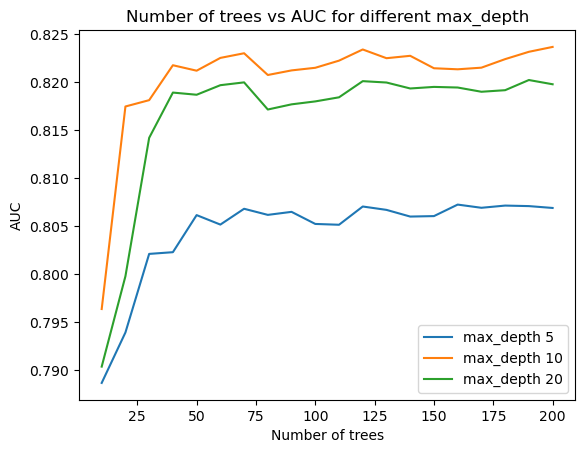

In [60]:
for depth in [5, 10, 20]:
    df_subset = df_scores[df_scores.max_depth == depth]
    plt.plot(df_subset.n_estimators, df_subset.auc, label = f'max_depth {depth}')

plt.title('Number of trees vs AUC for different max_depth')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.legend()

#### So `max_depth = 10` is the best depth for our Random Forrest

#### Tuninig the `min_samples_leaf` parameter:

In [61]:
max_depth = 10
aucs = []

for m in [1, 3, 5, 10, 50]:
    print(f'min_samples_leaf: {m}')
    
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators = n,
                                    max_depth = max_depth,
                                    min_samples_leaf = m,
                                    random_state = 3)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)

        print('%3s -> %.3f' % (n, auc))
        aucs.append((m, n, auc))
    print()

min_samples_leaf: 1
 10 -> 0.796
 20 -> 0.817
 30 -> 0.818
 40 -> 0.822
 50 -> 0.821
 60 -> 0.823
 70 -> 0.823
 80 -> 0.821
 90 -> 0.821
100 -> 0.822
110 -> 0.822
120 -> 0.823
130 -> 0.823
140 -> 0.823
150 -> 0.821
160 -> 0.821
170 -> 0.822
180 -> 0.822
190 -> 0.823
200 -> 0.824

min_samples_leaf: 3
 10 -> 0.812
 20 -> 0.823
 30 -> 0.829
 40 -> 0.829
 50 -> 0.828
 60 -> 0.825
 70 -> 0.825
 80 -> 0.824
 90 -> 0.823
100 -> 0.823
110 -> 0.823
120 -> 0.823
130 -> 0.824
140 -> 0.822
150 -> 0.823
160 -> 0.823
170 -> 0.823
180 -> 0.823
190 -> 0.823
200 -> 0.823

min_samples_leaf: 5
 10 -> 0.812
 20 -> 0.820
 30 -> 0.821
 40 -> 0.824
 50 -> 0.824
 60 -> 0.825
 70 -> 0.827
 80 -> 0.826
 90 -> 0.826
100 -> 0.825
110 -> 0.826
120 -> 0.825
130 -> 0.825
140 -> 0.825
150 -> 0.826
160 -> 0.826
170 -> 0.826
180 -> 0.826
190 -> 0.825
200 -> 0.825

min_samples_leaf: 10
 10 -> 0.808
 20 -> 0.817
 30 -> 0.821
 40 -> 0.822
 50 -> 0.823
 60 -> 0.822
 70 -> 0.821
 80 -> 0.819
 90 -> 0.820
100 -> 0.820
110 ->

In [62]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(aucs, columns=columns)

df_scores.sort_values(by = 'auc', ascending = False).head()

,min_samples_leaf,n_estimators,auc
22,3,30,0.829403
23,3,40,0.828658
24,3,50,0.827817
46,5,70,0.826672
56,5,170,0.826079


In [63]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]

list(zip(min_samples_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

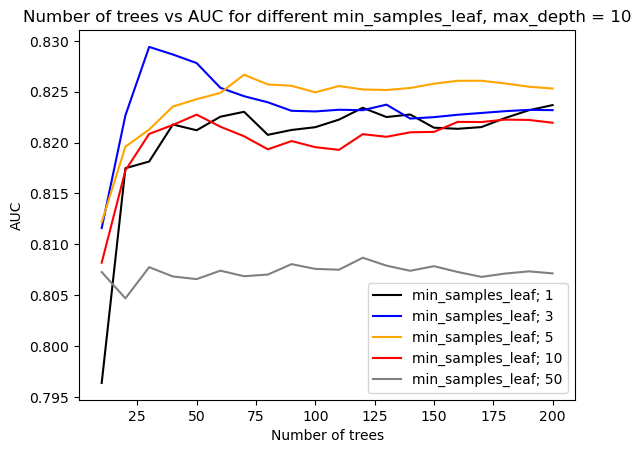

In [64]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]

for m, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == m]
    plt.plot(df_subset.n_estimators, df_subset.auc, color = col,
             label = f'min_samples_leaf; {m}')

plt.title('Number of trees vs AUC for different min_samples_leaf, max_depth = 10')
plt.xlabel('Number of trees')
plt.ylabel('AUC')
plt.legend()

**Selected Parameters:**

- `max_depth = 10`
- `min_samples_leaf = 3`
- `n_estimators = 30`

In [65]:
max_depth = 10
min_samples_leaf = 3
n_estimators = 30

In [66]:
rf = RandomForestClassifier(n_estimators = n_estimators,
                                    max_depth = max_depth,
                                    min_samples_leaf = min_samples_leaf,
                                    random_state = 3)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)

print(f'AUC = {auc.round(3)}')

AUC = 0.829


Other useful parameters
- `max_features`
- `bootstrap`

# 6.7 Gradient boosting and XGBoost
- Gradiant boosting vs random forrest
- Installing XGBoost
- Training the first model
- Performance monitoring
- Parsing XGBoost's monitoring output

In [265]:
import xgboost as xgb

In [266]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [267]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'verbosity': 1,
    'seed': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round = 10)

In [268]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8152745150274878

#### Now we want to observe what is happening in each step of boosting

In [71]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [72]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'verbosity': 1,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round = 200)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

To capture this output, we can use

- %%capture instruction that saves the result to output
- parse_xgb_output function that parses it

In [73]:
%%capture output
model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round = 200)

In [74]:
print(output.stdout)

[0]	train-auc:0.86300	val-auc:0.76818
[5]	train-auc:0.92863	val-auc:0.80606
[10]	train-auc:0.95002	val-auc:0.81558
[15]	train-auc:0.96558	val-auc:0.81680
[20]	train-auc:0.97316	val-auc:0.81775
[25]	train-auc:0.98174	val-auc:0.81878
[30]	train-auc:0.98772	val-auc:0.81787
[35]	train-auc:0.99180	val-auc:0.81510
[40]	train-auc:0.99456	val-auc:0.81387
[45]	train-auc:0.99596	val-auc:0.81462
[50]	train-auc:0.99688	val-auc:0.81128
[55]	train-auc:0.99787	val-auc:0.80874
[60]	train-auc:0.99889	val-auc:0.80801
[65]	train-auc:0.99919	val-auc:0.80751
[70]	train-auc:0.99944	val-auc:0.80732
[75]	train-auc:0.99964	val-auc:0.80692
[80]	train-auc:0.99985	val-auc:0.80677
[85]	train-auc:0.99986	val-auc:0.80671
[90]	train-auc:0.99992	val-auc:0.80637
[95]	train-auc:0.99996	val-auc:0.80580
[100]	train-auc:0.99998	val-auc:0.80508
[105]	train-auc:0.99999	val-auc:0.80603
[110]	train-auc:1.00000	val-auc:0.80527
[115]	train-auc:1.00000	val-auc:0.80382
[120]	train-auc:1.00000	val-auc:0.80431
[125]	train-auc:1.0000

In [75]:
s = output.stdout
line = s.split('\n')[0]
line

'[0]\ttrain-auc:0.86300\tval-auc:0.76818'

In [76]:
line.split('\t')

['[0]', 'train-auc:0.86300', 'val-auc:0.76818']

In [77]:
num_iter, train_auc, val_auc = line.split('\t')
num_iter, train_auc, val_auc

('[0]', 'train-auc:0.86300', 'val-auc:0.76818')

In [78]:
int(num_iter.strip('[]'))

0

In [79]:
float(train_auc.split(':')[1])

0.863

In [80]:
float(val_auc.split(':')[1])

0.76818

In [81]:
def parse_xgb_output(output):
    results = []
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns = columns)
    return df_results

In [82]:
df_scores = parse_xgb_output(output)

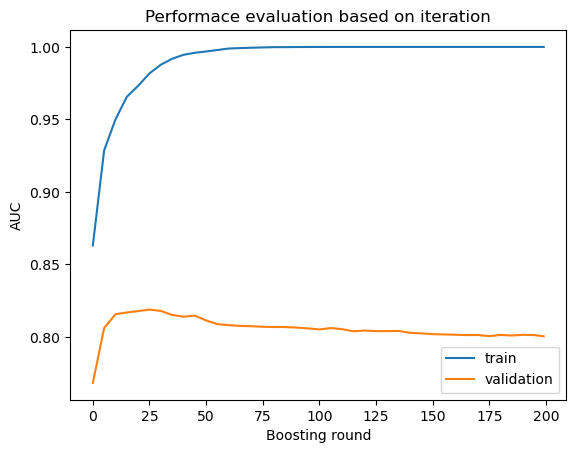

In [86]:
plt.plot(df_scores.num_iter, df_scores.train_auc, label = 'train')
plt.plot(df_scores.num_iter, df_scores.val_auc, label = 'validation')

plt.title('Performace evaluation based on iteration')
plt.xlabel('Boosting round')
plt.ylabel('AUC')
plt.legend()

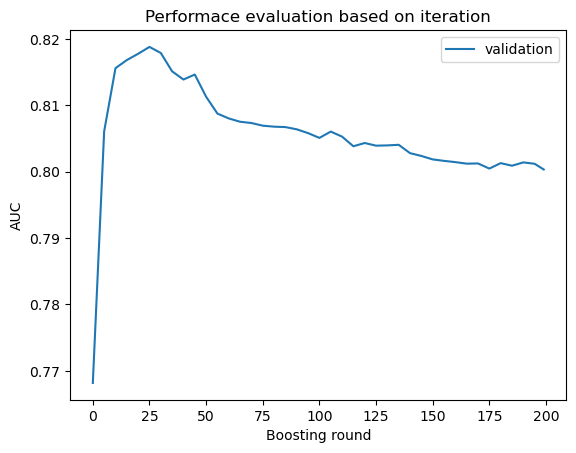

In [84]:
plt.plot(df_scores.num_iter, df_scores.val_auc, label = 'validation')

plt.title('Performace evaluation based on iteration')
plt.xlabel('Boosting round')
plt.ylabel('AUC')
plt.legend()

In [85]:
df_scores.sort_values(by='val_auc', ascending=False)

,num_iter,train_auc,val_auc
5,25,0.98174,0.81878
6,30,0.98772,0.81787
4,20,0.97316,0.81775
3,15,0.96558,0.81680
2,10,0.95002,0.81558
7,35,0.99180,0.81510
9,45,0.99596,0.81462
8,40,0.99456,0.81387
10,50,0.99688,0.81128
11,55,0.99787,0.80874


# 6.8 XGBoost Parameter Tuning
- eta: learning rate
- max_depth
- min_child_weight (same as min_samples_leaf in Random Forest)

#### Tuning the eta for 0.3, 1.0, 0.1, 0.05, 0.01

In [145]:
scores = {}
# for eta: 0.3, 1.0, 0.1, 0.05, 0.01

In [133]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'verbosity': 1,
    'seed': 1
}

In [134]:
%%capture output
model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round = 200)

In [135]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

In [136]:
scores.keys()

dict_keys(['eta=0.3', 'eta=1.0', 'eta=0.1', 'eta=0.05', 'eta=0.01'])

In [123]:
scores['eta=1.0']

,num_iter,train_auc,val_auc
0,0,0.86300,0.76818
1,5,0.95852,0.79032
2,10,0.98435,0.77716
3,15,0.99550,0.78110
4,20,0.99824,0.78091
5,25,0.99980,0.78252
6,30,0.99995,0.77850
7,35,1.00000,0.77592
8,40,1.00000,0.77689
9,45,1.00000,0.77701


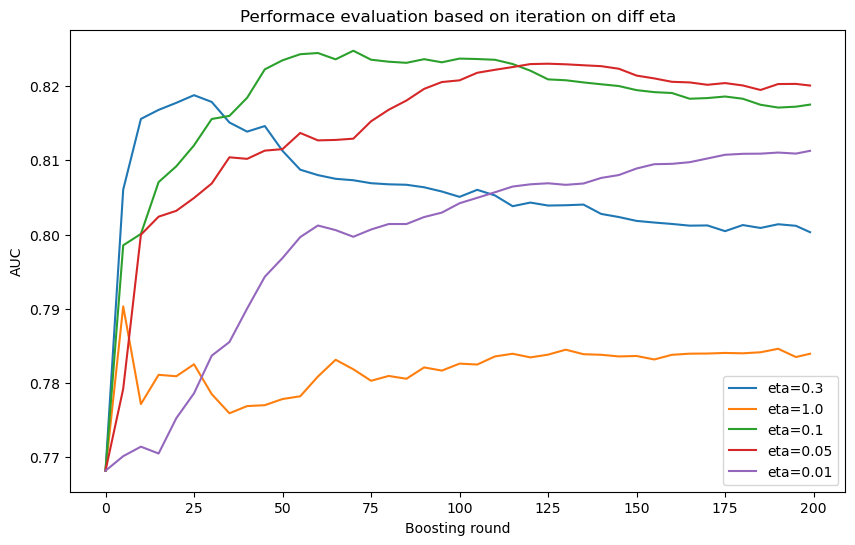

In [144]:
plt.figure(figsize=(10, 6))
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label = f'{key}')

    plt.title('Performace evaluation based on iteration on diff eta')
    plt.xlabel('Boosting round')
    plt.ylabel('AUC')
plt.legend()

#### eta = 0.1 is the best.
so `eta = 0.1`

#### Tuning the max_depth for 3, 6, 10, 20

In [163]:
scores = {}
# for eta: 3, 6, 10, 20

In [176]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 20,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'verbosity': 1,
    'seed': 1
}

In [177]:
%%capture output
model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round = 200)

In [178]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)

In [179]:
scores.keys()

dict_keys(['max_depth=3', 'max_depth=6', 'max_depth=10', 'max_depth=20'])

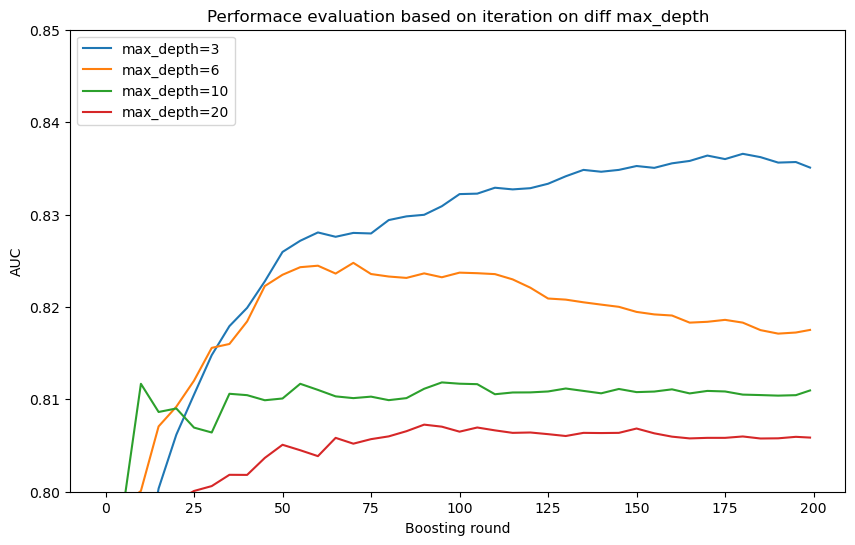

In [186]:
plt.figure(figsize=(10, 6))
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label = key)

plt.title('Performace evaluation based on iteration on diff max_depth')
plt.xlabel('Boosting round')
plt.ylabel('AUC')
plt.ylim(0.8, 0.85)
plt.legend(loc='upper left')

For max_depth = 3, we get the most stable AUC.
So selected `max_depth = 3`

#### Tuning the min_child_weight for 1, 5, 10, 20, 30

In [191]:
scores = {}
# for eta: 3, 6, 10, 20

In [208]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'verbosity': 1,
    'seed': 1
}

In [209]:
%%capture output
model = xgb.train(xgb_params, dtrain, evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round = 200)

In [210]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)

In [211]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=5', 'min_child_weight=10', 'min_child_weight=20', 'min_child_weight=30'])

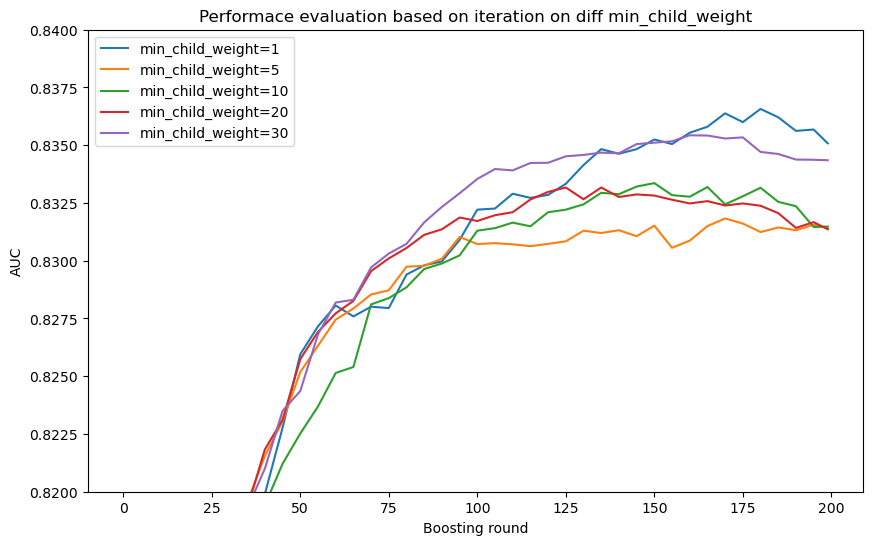

In [213]:
plt.figure(figsize=(10, 6))
for key, df_scores in scores.items():
    plt.plot(df_scores.num_iter, df_scores.val_auc, label = key)

plt.title('Performace evaluation based on iteration on diff min_child_weight')
plt.xlabel('Boosting round')
plt.ylabel('AUC')
plt.ylim(0.82, 0.84)
plt.legend(loc='upper left')

`min_child_weight = 1`, the default value is the best pic for min_child weight
`num_boost_round = 170-180`

#### Final model

In [238]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'verbosity': 1,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round = 180)

In [239]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8364807100821002

Other parameters: https://xgboost.readthedocs.io/en/stable/parameter.html                 
Useful Ones:
- subsample and colsample_bytree
- lambda and alpha

# Selecting the final model
- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [271]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'verbosity': 1,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round = 180)

dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf=15)
dt.fit(X_train, y_train)

max_depth = 10
min_samples_leaf = 3
n_estimators = 30

rf = RandomForestClassifier(n_estimators = n_estimators,
                                    max_depth = max_depth,
                                    min_samples_leaf = min_samples_leaf,
                                    random_state = 3)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=30,
                       random_state=3)

In [272]:
y_pred = dt.predict_proba(X_val)[:, 1]
dt_auc = roc_auc_score(y_val, y_pred)
print(f'DT AUC = {dt_auc}')

y_pred = rf.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, y_pred)
print(f'RF AUC = {rf_auc}')

y_pred = model.predict(dval)
xgb_auc = roc_auc_score(y_val, y_pred)
print(f'XGB AUC = {xgb_auc}')

DT AUC = 0.785470804775859
RF AUC = 0.8294028965149789
XGB AUC = 0.8364807100821002


#### Training on df_full_train

In [252]:
del df_full_train['status']
df_full_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
1,8,other,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
2,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
4,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750


In [273]:
dv = DictVectorizer(sparse=False)

full_train_dicts = df_full_train.fillna(0).to_dict(orient = 'records')
X_full_train = dv.fit_transform(full_train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient = 'records')
X_test = dv.transform(test_dicts)

features = dv.get_feature_names_out()
dfulltrain = xgb.DMatrix(X_full_train, label = y_full_train, feature_names = features)
dtest = xgb.DMatrix(X_test, feature_names = features)

In [276]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'verbosity': 1,
    'seed': 1
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round = 180)

dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf=15)
dt.fit(X_full_train, y_full_train)

max_depth = 10
min_samples_leaf = 3
n_estimators = 30

rf = RandomForestClassifier(n_estimators = n_estimators,
                                    max_depth = max_depth,
                                    min_samples_leaf = min_samples_leaf,
                                    random_state = 3)
rf.fit(X_full_train, y_full_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=30,
                       random_state=3)

In [278]:
y_pred = dt.predict_proba(X_test)[:, 1]
dt_auc = roc_auc_score(y_test, y_pred)
print(f'DT AUC = {dt_auc}')

y_pred = rf.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_pred)
print(f'RF AUC = {rf_auc}')

y_pred = model.predict(dtest)
xgb_auc = roc_auc_score(y_test, y_pred)
print(f'XGB AUC = {xgb_auc}')

DT AUC = 0.7746902644054543
RF AUC = 0.8197546551976932
XGB AUC = 0.8327366697619862
